# Machine learning training for KH
*NOTE* You need to set the environment variable "AIRFOILS_DLMC_KH_DATAPATH" to the folder containing "kh_1.nc" and "qmc_points.txt"

In [1]:
import sys
import time
sys.path.append('../python')
from plot_info import *
from keras.models import Sequential
from keras.layers import Dense, Activation
import keras
random_seed = 42

import numpy.random
import tensorflow

def seed_random_number(seed):
    numpy.random.seed(seed)
    tensorflow.set_random_seed(seed)
    
seed_random_number(random_seed)
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import netCDF4
import os.path
import scipy
import scipy.stats
input_size=40
train_size=128
validation_size=200
import os
from print_table import *

data_path=os.path.join(os.environ['AIRFOILS_DLMC_KH_DATAPATH'], 'kh_1.nc')

Using TensorFlow backend.


In [2]:
class ProgressKeras(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        pass

    def on_batch_end(self, batch, logs={}):
        sys.stdout.write("Current batch: %d\r" %batch)
        sys.stdout.flush()

In [3]:

class AreaFunctional(object):
    def __init__(self, integrate_coordinate = [0.55,0.35], integrate_width=[0.25,0.25],variable='rho', 
                 short_title=None):
        self.integrate_coordinate = integrate_coordinate
        self.integrate_width = integrate_width
        
        self.variable = variable
        self.first = 10
        
        if short_title is None:
            self.short_title = self.title()
        else:
            self.short_title = short_title
        
    def short_title(self):
        return self.short_title
        
    def title(self):
        return 'integrated area: $[%.2f,%.2f]\\times [%.2f,%.2f]$'% (self.integrate_coordinate[0],
                                                            self.integrate_coordinate[0]+self.integrate_width[0],
                                                            self.integrate_coordinate[1],
                                                            self.integrate_coordinate[1]+self.integrate_width[1])
    def area(self, I):
        
        return 1*(I[1][0]-I[0][0])*(I[1][1]-I[0][1])
    def __call__(self, rho):
        N = rho.shape[0]
        
        integrate_area = [[int(N*self.integrate_coordinate[0]), int(N*self.integrate_coordinate[1])],
                          [int(N*self.integrate_coordinate[0]+N*self.integrate_width[0]), 
                           int(N*self.integrate_coordinate[1]+N*self.integrate_width[1])]]
        
        g = sum(rho[integrate_area[0][0]:integrate_area[1][0], integrate_area[0][1]:integrate_area[1][1]])/self.area(integrate_area)
        
      
        return g
    
    def plot(self, d):
        N = d.shape[0]
        x, y= mgrid[0:1:N*1j,0:1:N*1j]
        plt.pcolormesh(x,y,d)
        rect = matplotlib.patches.Rectangle((self.integrate_coordinate[0],self.integrate_coordinate[1]),
                                     self.integrate_width[0],
                                     self.integrate_width[1],
                                     linewidth=1,edgecolor='r',facecolor='none')
        
        axes = plt.gca()
        axes.add_patch(rect)
        
        
        
class SinglePointFunctional(object):
    def __init__(self, coordinate = [0.55,0.35], variable='rho'):
        self.coordinate = coordinate
        
        self.variable = variable
        self.first = 10
         
    def short_title(self):
        return '$(%f,%f)$'% (self.coordinate[0], self.coordinate[1])
    def title(self):
        return 'specific point  $(%f,%f)$'% (self.coordinate[0], self.coordinate[1])

    def __call__(self, rho):
        N = rho.shape[0]
        
        x = int(N*self.coordinate[0])
        y = int(N*self.coordinate[1])
        
        return rho[x,y]
    
    def plot(self, d):
        N = d.shape[0]
        x, y= mgrid[0:1:N*1j,0:1:N*1j]
        plt.pcolormesh(x,y,d)
        rect = matplotlib.patches.Rectangle((self.coordinate[0],self.coordinate[1]),
                                     0.05,
                                     0.05,
                                     linewidth=1,edgecolor='r',facecolor='r')
        
        axes = plt.gca()
        axes.add_patch(rect)
        
    
    

In [4]:
def get_samples(data_path, functional):
    samples = []
    
    with netCDF4.Dataset(data_path) as f:
        for k in f.variables.keys():
            if functional.variable in k:
                sys.stdout.write("%d\r" % len(samples))
                sys.stdout.flush()
                samples.append(functional(f.variables[k][:,:,0]))
                
               
    print()
    return array(samples,dtype=float64)
def draw_functional(data_path, functional):
    with netCDF4.Dataset(data_path) as f:
        d = f.variables['sample_10_%s' % functional.variable][:,:,0]
        functional.plot(d)
        

                

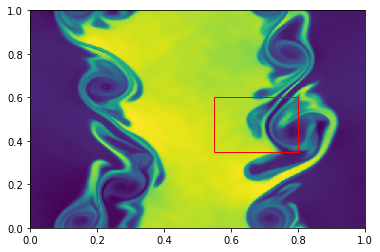

In [5]:
draw_functional(data_path, AreaFunctional())

In [6]:
def get_network_from_functional(data_path, functional, parameters, epochs=500000, optimizer=keras.optimizers.SGD):
    start_reading_samples = time.time()
    samples = get_samples(data_path, functional)
    end_reading_samples = time.time()
    print("Reading all samples took {} seconds".format(end_reading_samples-start_reading_samples))
    return get_network(parameters, samples, train_size=train_size, validation_size=validation_size, epochs=epochs,
                      title=functional.title(), optimizer=optimizer)
def get_network_from_functional_qmc(data_path, functional,epochs=500000, optimizer=keras.optimizers.SGD):
    parameter_path = os.path.join(os.path.dirname(data_path), 'qmc_points.txt')
    parameters = loadtxt(parameter_path)
    
    return get_network_from_functional(data_path, functional, parameters, epochs,optimizer=optimizer)
def get_network(parameters, data, *, train_size, validation_size, epochs=500000, title='', 
                optimizer=keras.optimizers.SGD):
    import numpy as np
    
    print(type(data))
    print(data.shape)
    if np.isnan(data).any():
        print("We have a nan!")
    if np.isinf(data).any():
        print("we have an inf!")
        
    input_size = parameters.shape[1]
    
    best_network = None
    best_network_index = None
    best_learning_rate = None
    
    
    tries = 5
    start_total_learning = time.time()
    for trylearn in range(tries):
        model = Sequential([
            Dense(20, input_shape=(input_size,)),
            Activation('relu'),
            Dense(22),
            Activation('relu'),
            Dense(20),
            Activation('relu'),
            Dense(22),
            Activation('relu'),
            Dense(20),
            Activation('relu'),
            Dense(20),
            Activation('relu'),
            Dense(1)
        ])
        
        
        
       
        model.compile(optimizer=optimizer(lr=0.01),
                      loss='mean_squared_error')
        
        weights = np.copy(model.get_weights())
        x_train = parameters[:train_size,:]
      
        y_train=data[:train_size]
        
        
        x_val = parameters[train_size:validation_size+train_size,:]
        y_val=data[train_size:train_size+validation_size]
       
        epochs_r=range(1, epochs)
       
        start_training_time = time.time()
        hist = model.fit(x_train, y_train,batch_size=train_size, epochs=epochs,shuffle=True, 
                         validation_data=(x_val, y_val),verbose=0, 
                         callbacks=[ProgressKeras()])
        print()
        end_training_time = time.time()
        print("Training took {} seconds".format(end_training_time-start_training_time))
        console_log("Training took {} seconds".format(end_training_time-start_training_time))
        
        train_error = np.sum(hist.history['loss'][-max(epochs//1000,1):])
        if best_network is None or train_error < best_learning_rate:
            best_network = model
            best_network_index = trylearn
            best_learning_rate = train_error
            best_weights = weights
            
    end_total_learning = time.time()
    
    print("Best network index: %d" % best_network_index)
    console_log("Best network index: %d" % best_network_index)
    print("Total learning time took: %d s" % (end_total_learning-start_total_learning))
    console_log("Total learning time took: %d s" % (end_total_learning-start_total_learning))
    model = best_network
    weights = best_weights    
    
    print_keras_model_as_table('khnetwork', model)
    # save model to file, see https://machinelearningmastery.com/save-load-keras-deep-learning-models/
    model_json = model.to_json()
    with open("results/" + showAndSave.prefix + "model.json", "w") as json_file:
        json_file.write(model_json)
    model.save_weights("results/" + showAndSave.prefix + "model.h5")
    np.save("results/" + showAndSave.prefix + "intial.npy", weights)
    
    plt.loglog(hist.history['loss'])
    plt.title("Training loss\n%s\n(epochs=%d)" % (title, epochs))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    showAndSave("training_loss")
    
    plt.loglog(hist.history['val_loss'])
    plt.title("Validation loss\n%s\n(epochs=%d)" % (title, epochs))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    showAndSave("validation_loss")
    
    
    end_training_time = time.time()
    print("Training took {} seconds".format(end_training_time-start_training_time))
    plt.loglog(hist.history['loss'],label="Training loss")
    plt.loglog(hist.history['val_loss'], label='Validation loss')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title("Training and validation loss\n%s\n(epochs=%d)" % (title, epochs))
    showAndSave("training_validation_loss")
    
    x_test = parameters
    y_test = data
    y_predict = model.predict(x_test)
    print(y_test.shape)
    print(y_predict.shape)
    plt.scatter(y_test, y_predict[:,0])
    plt.title("Scatter plot, \n%s,\n epochs=%d" % (title, epochs))
    plt.xlabel("Actual data")
    plt.ylabel("Predicted data")
    showAndSave("scatter_ml")
    print(model.summary())
    print("Number of parameters: %d"% model.count_params())
    
    return  model, data, parameters

In [7]:
def get_network_interpolate_qmc(data_path, functional, epochs=500000, *, optimizer=keras.optimizers.SGD,
                                speedup_table, comparison_table, 
                                wasserstein_table_builder,
                                   bilevel_speedup_table,
                               prediction_error_table):
    console_log("Doing next configuration")
    draw_functional(data_path, functional)
    showAndSave('functional_plot')
    network, data, parameters = get_network_from_functional_qmc(data_path, functional, epochs, optimizer=optimizer)
    
    from sklearn import linear_model
    reg = linear_model.LinearRegression()
    y_train = data[:train_size]
    coeffs = reg.fit(parameters[:train_size,:], y_train)

    evaluated_lsq = coeffs.predict(parameters)
    plt.scatter(data, evaluated_lsq)
    plt.title('Linear least squares\n%s' % functional.title())
    plt.xlabel("Actual data")
    plt.ylabel("Interpolated data")
    showAndSave('scatter_lsq')
    
    def myvar(x):
        mean = sum(x)/x.shape[0]
        var = sum((mean-x)**2)/x.shape[0]
        return var
    
    def mymean (x): 
        return sum(x)/x.shape[0]
    
    
   
    
    variance_top = myvar(data)
    print("variance single level = %f" % variance_top)
    predicted = network.predict(parameters)
    predicted = predicted.reshape(parameters.shape[0])
    variance_diff_ml = myvar(data- predicted)
    
    
    print("variance diff ml = %f " % variance_diff_ml)
    print("speedup = %f" % (variance_top/variance_diff_ml))
    
    bilevel_speedup_table.set_header(["Functional", "DLbQMC Speedup"])
    bilevel_speedup_table.add_row([functional.short_title(), variance_top/variance_diff_ml])
    print((data - evaluated_lsq).shape)
    variance_diff_interpolate =myvar(data - evaluated_lsq)
    print("variance_diff_interpolate = %f" % variance_diff_interpolate)
    
    mean_qmc = mymean(data)
    print("mean_qmc = %f" % mean_qmc)
    mean_ml = mymean(network.predict(parameters))
    print("mean_ml = %f" % mean_ml)
    mean_few_qmc = mymean(parameters[:train_size,:])
    
    
    
    
    
    
    predicted_all = network.predict(parameters)
    predicted_all = predicted_all.reshape(parameters.shape[0])
    print(predicted_all.shape)
    mean_mlmlmc = mymean(predicted[:train_size]-data[:train_size]) + mymean(predicted_all)
    
    print("mean_mlmlmc = %f" % mean_mlmlmc)
    var_qmc = myvar(data)
    print("var_qmc = %f" % var_qmc)
    var_ml = myvar(network.predict(parameters))
    print("var_ml = %f" % var_ml)
    var_few_qmc = myvar(parameters[:train_size,:])
    
    print("var_few_qmc = %f" % var_few_qmc)
    print(parameters.shape)
    print("var_lsq = %f" % var(evaluated_lsq))
    
    title = functional.title()
    plt.hist(data,bins=40,density=True,label='QMC 8192 samples',alpha=0.5)
    plt.title("Comparison QMC and DLQMC\n%s\nepochs=%d"% (title, epochs))
    plt.hist(network.predict(parameters),bins=40,density=True,label='DLQMC(%d samples)' % train_size,alpha=0.5)
    plt.legend()
    showAndSave('hist_qmc_ml')
    
    
    plt.title("Comparison QMC with %d and QMC with %d samples\n%s" %(8192, train_size, title))
    plt.hist(data,bins=40,density=True,label='QMC 8192 samples',alpha=0.5)
    plt.hist(data[:train_size],bins=40,density=True, alpha=0.5,label='QMC %d samples' % train_size)
    plt.legend()
    showAndSave('hist_qmc_qmc')
    
    plt.title("Comparison QMC with least squares\n%s" % title)
    plt.hist(data,bins=40,density=True,label='QMC 8192 samples',alpha=0.5)
    plt.hist(evaluated_lsq,bins=40,density=True,alpha=0.5, label='Least squares (%d points)' % train_size)
    plt.legend()
    showAndSave('hist_qmc_lsq')
    
    
    prediction_error = np.sum(keras.backend.eval(keras.losses.mean_squared_error(data, model.predict(parameters))))/data.shape[0]
    prediction_error_lsq = np.sum(keras.backend.eval(keras.losses.mean_squared_error(data, evaluated_lsq)))/data.shape[0]
    
    print(prediction_error)
    
    
    prediction_error_table.set_header(["Functional", "Deep learning", "Least squares"])
    prediction_error_table.add_row([functional.short_title(), prediction_error, prediction_error_lsq])
    
    
    
    
    
    
    model = network
    samples = range(0,data.shape[0])
    stats = {}
    for stat in ['mean', 'var']:
        stats[stat]={}
        stats[stat]['sources']={}
        if stat == 'mean':
            stats[stat]['compute']=lambda x: sum(x)/x.shape[0]
        else:
            stats[stat]['compute']=lambda x: sum(x**2)/x.shape[0]-(sum(x)/x.shape[0])**2
    
     
        stats[stat]['sources']['QMC']={}
        stats[stat]['sources']['DLQMC'] = {}
        stats[stat]['sources']['Least squares'] = {}
        stats[stat]['sources']['DLbQMC'] = {}
    
        stats[stat]['sources']['QMC']['data']=array([stats[stat]['compute'](data[:k]) for k in samples])
        stats[stat]['sources']['DLQMC']['data'] = array([stats[stat]['compute'](array(model.predict(parameters[:k,:]))) for k in samples])
        stats[stat]['sources']['Least squares']['data'] = array([stats[stat]['compute'](evaluated_lsq[:k]) for k in samples])
        
        stats[stat]['sources']['DLbQMC']['data'] = [0]
        
        for k in samples[1:]:
            if stat == 'mean':
                mean = sum(model.predict(parameters[:train_size,:])-data[:train_size])/train_size +\
                sum(model.predict(parameters[:k,:]))/k
                

                stats[stat]['sources']['DLbQMC']['data'].append(mean)
            elif stat=='var':
                mean = sum(model.predict(parameters[:train_size,:])-data[:train_size])/train_size +\
                sum(model.predict(parameters[:k,:]))/k
                
                m2 = sum((data[:train_size])**2-(model.predict(parameters[:train_size,:]))**2)/train_size +\
                sum(model.predict(parameters[:k,:])**2)/k
                

                stats[stat]['sources']['DLbQMC']['data'].append(m2-mean**2)
                
        stats[stat]['sources']['DLbQMC']['data']=array(stats[stat]['sources']['DLbQMC']['data'])
        
        sources = stats[stat]['sources'].keys()
        for source in sources:
            
            stats[stat]['sources'][source]['representative'] = stats[stat]['sources'][source]['data'][-1]
            
        
       
    
        for source in stats[stat]['sources'].keys():
            if 'DLbQMC' not in source:
                plt.plot(samples, stats[stat]['sources'][source]['data'], label=source)
        plt.xlabel('Number of samples ($J_L$)')
        plt.ylabel('%s' % stat)
        plt.title('%s as a function of number of samples used for evaluation\n%s' % (stat, title))
        plt.legend()
        showAndSave('function_of_samples_airfoil_%s_%s'  % (stat, title))
        stats[stat]['sources']['QMC\\_%d' % train_size] = {}
        stats[stat]['sources']['QMC\\_%d' % train_size]['representative'] = stats[stat]['sources']['QMC']['data'][train_size]
    sources = [source for source in stats['mean']['sources'].keys()]
    datatable = [[],[],[]]
    for source in sources:
        if source != sources[-1]:
            sys.stdout.write('\\multicolumn{2}{c|}{\\textbf{%s}} &&' % source)
        else:
            sys.stdout.write('\\multicolumn{2}{c|}{\\textbf{%s}} \\\\ \n' % source)
        
        datatable[0].append(source)
    comparison_table.set_upper_header(datatable[0])
    sys.stdout.write("&")
    for source in sources:
        for stat in ['mean', 'var']:
            if not (stat == 'var' and source ==  sources[-1]):
                sys.stdout.write("%s &" % stat)
            else:
                sys.stdout.write("%s \\\\ " % stat)
                
            if stat == 'var' and source != sources[-1]:
                sys.stdout.write("& ")
            else:
                sys.stdout.write(" ")
            datatable[1].append(stat)
    comparison_table.set_lower_header(datatable[1])
    sys.stdout.write("%s & " % title)
    for source in sources:
        for stat in ['mean', 'var']:
            if not (stat == 'var' and source ==  sources[-1]):
                sys.stdout.write("%.5f &" % stats[stat]['sources'][source]['representative'])
            else:
                sys.stdout.write("%.5f \\\\ \n" % stats[stat]['sources'][source]['representative'])
            
            if stat == 'var' and source != sources[-1]:
                sys.stdout.write("& ")
            else:
                sys.stdout.write(" ")
            datatable[2].append(stats[stat]['sources'][source]['representative'])
            
            
    comparison_table.add_row([functional.short_title()]+datatable[2])
    print_comparison_table('comparison_stats', datatable, multicolumn=True)
    
    
    #### Speedup
    speeduptable = [[],[],[]]
    statstouse = ['mean', 'var']
    baseline='QMC'
    small_baseline = 'QMC\\_%d' % train_size
    competitors = ['QMC\\_%d' % train_size, 'DLQMC', 'DLbQMC', 'Least squares']
    sys.stdout.write("&")
    for competitor in competitors:
        speeduptable[0].append(competitor)
        if competitor != competitors[-1]:
            sys.stdout.write('\\multicolumn{2}{c|}{\\textbf{%s}} &&' % competitor)
        else:
            sys.stdout.write('\\multicolumn{2}{c|}{\\textbf{%s}} \\\\ \n' % competitor)
    speedup_table.set_upper_header(speeduptable[0])
    sys.stdout.write("&")
    for source in competitors:
        for stat in ['mean', 'var']:
            speeduptable[1].append(stat)
            if not (stat == 'var' and competitor ==  competitors[-1]):
                sys.stdout.write("%s &" % stat)
            else:
                sys.stdout.write("%s \\\\ " % stat)
                
            if stat == 'var' and competitor != competitors[-1]:
                sys.stdout.write("& ")
            else:
                sys.stdout.write(" ")
    speedup_table.set_lower_header(speeduptable[1])
    sys.stdout.write("%s & " % title)
    
    for competitor in competitors:
        for stat in ['mean', 'var']:
            
            console_log(competitor)
            console_log(stat)
            console_log(stats[stat])
            console_log(stats[stat]['sources'])
            console_log(stats[stat]['sources'][competitor])
            console_log(stats[stat]['sources'][baseline])
            console_log(stats[stat]['sources'][competitor]['representative'])
            
            
            error = abs(stats[stat]['sources'][competitor]['representative']-\
                        stats[stat]['sources'][baseline]['representative'])
            
            error_base = abs(stats[stat]['sources'][small_baseline]['representative']-\
                             stats[stat]['sources'][baseline]['representative'])
            
            speedup = error_base/error
            if not (stat == 'var' and competitor ==  competitors[-1]):
                sys.stdout.write("%.5f &" % speedup)
            else:
                sys.stdout.write("%.5f \\\\ \n" % speedup)
            
            if stat == 'var' and source != sources[-1]:
                sys.stdout.write("& ")
            else:
                sys.stdout.write(" ")
            speeduptable[2].append(speedup)
    speedup_table.add_row([functional.short_title()] + speeduptable[2])
    print_comparison_table('comparison_speedup', speeduptable, multicolumn=True)
    for stat in ['mean', 'var']:
        errors_qmc = []
            
        for k in samples[1:-2]:
            errors_qmc.append(abs(stats[stat]['sources']['QMC']['representative']-\
                                      stats[stat]['sources']['QMC']['data'][k]))
        plt.loglog(samples[1:-2], errors_qmc, label='QMC error')
        plt.axvline(x=train_size, linestyle='--', color='grey')
        
        for competitor in ['DLbQMC', 'DLQMC', 'Least squares']:
            error = abs(stats[stat]['sources'][competitor]['representative']-stats[stat]['sources'][baseline]['representative'])
            
                
            
            plt.loglog(samples[1:-2], error*ones_like(samples[1:-2]), '--', label='%s error' % competitor)
        
        plt.xlabel('Number of samples for QMC')
        plt.ylabel('Error')
        plt.title('Error for %s compared to QMC\n%s' % (stat, title))
        plt.legend()
        showAndSave("error_evolution_%s" % stat)
                      
                
                
    ###### Speedup Wasserstein
    data_modified = data
    N_wasser = 2**(int(log2(data_modified.shape[0])))
    data_wasser = data_modified[:N_wasser]
    qmc_upscaled = repeat(data[:train_size], N_wasser/train_size)
    
    wasser_qmc_qmc = scipy.stats.wasserstein_distance(data_wasser, qmc_upscaled)
    wasser_qmc_ml = scipy.stats.wasserstein_distance(data_wasser, reshape(model.predict(parameters), data.shape))
    wasser_qmc_lsq = scipy.stats.wasserstein_distance(data_wasser, evaluated_lsq)
    
    speedup_qmc = wasser_qmc_qmc / wasser_qmc_qmc
    speedup_ml =  wasser_qmc_qmc / wasser_qmc_ml 
    speedup_lsq = wasser_qmc_qmc / wasser_qmc_lsq
    
    wasserstein_table=[["DLQMC", "Least squares", "QMC 128"],[speedup_ml, speedup_lsq, speedup_qmc]]
    print_comparison_table("wasserstein", wasserstein_table)
    
    wasserstein_table_builder.set_header(wasserstein_table[0])
    wasserstein_table_builder.add_row([functional.short_title()]+wasserstein_table[1])
    
    print("\\toprule")
    print("&DLQMC & Least squares & QMC 128\\\\")
    print("\\midrule")
    print("{} & {} & {} & {}".format(title, speedup_ml, speedup_lsq, speedup_qmc))
    
    
    errors_qmc = []
            
    for k in range(1, int(log2(data_modified.shape[0]))):
        qmc_upscaled = repeat(data_modified[:int(2**k)], N_wasser//int(2**k))
        errors_qmc.append(scipy.stats.wasserstein_distance(data_wasser, qmc_upscaled))
        
    samples_wasser = 2**array(range(1, int(log2(data_modified.shape[0]))))
    plt.loglog(samples_wasser, errors_qmc, '-o', label='QMC error')
    
    plt.loglog(samples_wasser, wasser_qmc_ml*ones_like(samples_wasser), '--', label='DLMC error')
    plt.loglog(samples_wasser, wasser_qmc_lsq*ones_like(samples_wasser), '--', label='LSQ error')
    plt.axvline(x=train_size, linestyle='--', color='grey')
    plt.xlabel('Number of samples for QMC')
    plt.ylabel('Error (Wasserstein)')
    plt.title('Error (Wasserstein) compared to QMC\n%s' % title)
    plt.legend()
    showAndSave("error_evolution_wasserstein")
    
    console_log("done one configuration")
    
    return network, data, parameters

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


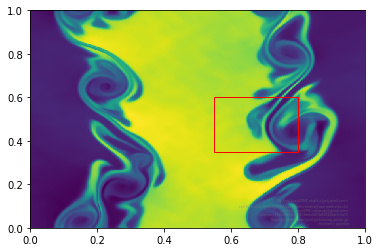

8191
Reading all samples took 161.3981966972351 seconds
<class 'numpy.ndarray'>
(8192,)
Current batch: 0
Training took 1741.1160249710083 seconds


In [ ]:
variables = ['rho']

points = [[0.55,0.35], [0.75,0.75]]
func_names=["$Q_2$", "$Q_1$"]

#for x in [0.25,0.5, 0.75]:
#    for y in [0.25,0.5,0.75]:
#        points.append([x,y])
epochs = [500000, 5000]
seed_random_number(random_seed)
display(HTML("<h1>Stochastic gradient</h1>"))
for v in variables:
    for epoch in epochs:
        speedup_table = TableBuilder()
        comparison_table = TableBuilder()
        wasserstein_table_builder = TableBuilder()
        bilevel_speedup_table= TableBuilder()
        prediction_error_table = TableBuilder()
        for (func_name, p) in zip(func_names, points):
        
        
            
            prefix = '%s_%f_%f' % (v, p[0], p[1])
            prefix = prefix.replace('.','_')
            showAndSave.prefix = 'kh_%d_%s' % (epoch, prefix)

            network, data, parameters = get_network_interpolate_qmc(data_path, 
                                                                    AreaFunctional(integrate_coordinate=p,
                                                                                   variable=v,
                                                                                   short_title=func_name),
                                                                    epoch, speedup_table=speedup_table,
                                                                   comparison_table=comparison_table,
                                                                   wasserstein_table_builder=wasserstein_table_builder,
                                                                bilevel_speedup_table=bilevel_speedup_table,
                                                                prediction_error_table=prediction_error_table)
        showAndSave.prefix = 'kh_all_%d_%s' % (epoch, v)
        speedup_table.print_table('speedup')
        comparison_table.print_table('comparison')
        wasserstein_table_builder.print_table("wasserstein")
        bilevel_speedup_table.print_table("bilevel_speedup")
        prediction_error_table.print_table("prediction_error_table")
display(HTML("<h1>Adams</h1>"))
seed_random_number(random_seed)
for v in variables:
    for epoch in epochs:
   
        speedup_table = TableBuilder()
        comparison_table = TableBuilder()
        wasserstein_table_builder = TableBuilder()
        bilevel_speedup_table= TableBuilder()
        prediction_error_table = TableBuilder()
        for (func_name, p) in zip(func_names, points):
        
            
            prefix = '%s_%f_%f' % (v, p[0], p[1])
            prefix = prefix.replace('.','_')
            showAndSave.prefix = 'kh_adams_%d_%s' % (epoch, prefix)

            network, data, parameters = get_network_interpolate_qmc(data_path, 
                                                                    AreaFunctional(integrate_coordinate=p,
                                                                                   variable=v,
                                                                                   short_title=func_name),
                                                                    epoch,
                                                                   optimizer=keras.optimizers.Adam,
                                                                    speedup_table=speedup_table,
                                                                   comparison_table=comparison_table,
                                                                   wasserstein_table_builder=wasserstein_table_builder,
                                                                    bilevel_speedup_table=bilevel_speedup_table,
                                                                    prediction_error_table=prediction_error_table)
        showAndSave.prefix = 'kh_all_adams_%d_%s' % (epoch, v)
        speedup_table.print_table('speedup')
        comparison_table.print_table('comparison')
        wasserstein_table_builder.print_table("wasserstein")
        bilevel_speedup_table.print_table("bilevel_speedup")
        prediction_error_table.print_table("prediction_error_table")